In [1]:
# People generally use pre trained models like BERT built on top of transformers 
# This is a general implementation of Transformers

In [2]:
import json
import tensorflow as tf
import numpy as np
import random
import re
import spacy

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
with open("data/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
print('Total', len(labels), 'lines of data.')

Total 26709 lines of data.


In [5]:
training_size = 20000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [6]:
index = random.randint(0,training_size-1)
print(training_sentences[index])
ref = {0:'No', 1:'Yes'}
print("Is Sarcastic?", ref[training_labels[index]])

j.crew debuts new line of stylish casualwear for mannequins
Is Sarcastic? Yes


In [7]:
model = "en_core_web_sm"
nlp = spacy.load(model)

In [8]:
def text_processing(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(' +', ' ', text)
    all_stopwords = nlp.Defaults.stop_words
    text = nlp(text)
    text_tokens = [token.lemma_ for token in text]
    tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]
    return " ".join(tokens_without_sw)

In [9]:
training_sentences = np.array(list(map(text_processing, training_sentences)))
testing_sentences = np.array(list(map(text_processing, testing_sentences)))

In [10]:
training_labels

array([0, 0, 1, ..., 0, 0, 1])

### Transformer

In [11]:
# Multi-headed attention
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [12]:
# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [13]:
# Embedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Prepare Data

In [14]:
vocab_size = 10000  # Only consider the top 10k words
maxlen = 70  # Only consider the first 70 words of each movie review
print(len(training_sentences), "Training sequences")
print(len(testing_sentences), "Validation sequences")

20000 Training sequences
6709 Validation sequences


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
trunc_type='post'
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

In [16]:
x_train = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=maxlen)

### Classifier Model with transformer layer

In [17]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

### Train and Evaluate

In [18]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
token_and_position_embedding (None, 70, 32)            322240    
_________________________________________________________________
transformer_block (Transform (None, 70, 32)            6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

In [19]:
history = model.fit(
    x_train, training_labels, epochs=30, validation_data=(x_val, testing_labels)
)

Epoch 1/30
625/625 [==============================] - 14s 15ms/step - loss: 0.6684 - accuracy: 0.5854 - val_loss: 0.4704 - val_accuracy: 0.7763
Epoch 2/30
625/625 [==============================] - 9s 14ms/step - loss: 0.3744 - accuracy: 0.8352 - val_loss: 0.4504 - val_accuracy: 0.7976
Epoch 3/30
625/625 [==============================] - 9s 14ms/step - loss: 0.2457 - accuracy: 0.9032 - val_loss: 0.4927 - val_accuracy: 0.7840
Epoch 4/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1773 - accuracy: 0.9314 - val_loss: 0.6021 - val_accuracy: 0.7855
Epoch 5/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1281 - accuracy: 0.9472 - val_loss: 0.7022 - val_accuracy: 0.7860
Epoch 6/30
625/625 [==============================] - 11s 18ms/step - loss: 0.1034 - accuracy: 0.9552 - val_loss: 0.8891 - val_accuracy: 0.7773
Epoch 7/30
625/625 [==============================] - 11s 18ms/step - loss: 0.0817 - accuracy: 0.9638 - val_loss: 0.9738 - val_accuracy: 0.7

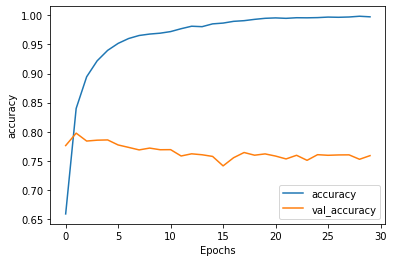

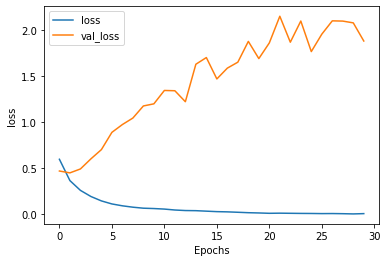

In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Testing

In [21]:
test = "'i want to be with someone else,' says woman who must think 3-time hyundai sales leaders grow on trees"
test = np.array([text_processing(test)])
test = tokenizer.texts_to_sequences(test)
test = keras.preprocessing.sequence.pad_sequences(test, maxlen=maxlen)

In [22]:
predict = model.predict(test)
predict[0].argmax()

0

In [23]:
test = "10 year olds will now work in google!"
test = np.array([text_processing(test)])
test = tokenizer.texts_to_sequences(test)
test = keras.preprocessing.sequence.pad_sequences(test, maxlen=maxlen)

In [24]:
predict = model.predict(test)
predict[0].argmax()

0